In [1]:
#Importing relavent modules
#https://www.sec.gov/data-research/sec-markets-data/financial-statement-data-sets
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
q1_num = pd.read_csv("Q1/num.csv", sep="\t")
q1_sub = pd.read_csv("Q1/sub.csv", sep="\t")
q1_tag = pd.read_csv("Q1/tag.csv", sep="\t")
q1_pre = pd.read_csv("Q1/pre.csv", sep="\t")

In [3]:
q2_num = pd.read_csv("Q2/num.csv", sep="\t")
q2_sub = pd.read_csv("Q2/sub.csv", sep="\t")
q2_tag = pd.read_csv("Q2/tag.csv", sep="\t")
q2_pre = pd.read_csv("Q2/pre.csv", sep="\t")
sic = pd.read_csv("AD/sic_name.csv", sep="\t")

In [4]:
q2_sub[q2_sub["name"].str.contains("JP", case=False)]

,adsh,cik,name,sic,countryba,stprba,cityba,zipba,bas1,bas2,...,period,fy,fp,filed,accepted,prevrpt,detail,instance,nciks,aciks
5272,0000019617-25-000421,19617,JPMORGAN CHASE & CO,6021.0,US,NY,NEW YORK,10017,383 MADISON AVENUE,NaN,...,20250331.0,2025.0,Q1,20250501,2025-05-01 16:17:00.0,0,1,jpm-20250331_htm.xml,1,NaN


In [5]:
#Competitive Benchmarking
competitors = q2_sub["adsh"][q2_sub["sic"] == 6021.0].unique()

In [6]:
# Merge q2_num with q2_sub on "adsh" so we have values + names aligned
merged = q2_num.merge(q2_sub[["adsh", "name"]], on="adsh", how="left")

# Filter to only competitor adsh
filtered = merged[merged["adsh"].isin(competitors)]

# Aggregate revenue per competitor
gross_rev = (
    filtered.groupby(["adsh", "name"])["value"]
    .sum()
    .reset_index()
    .rename(columns={"value": "rev"})
)

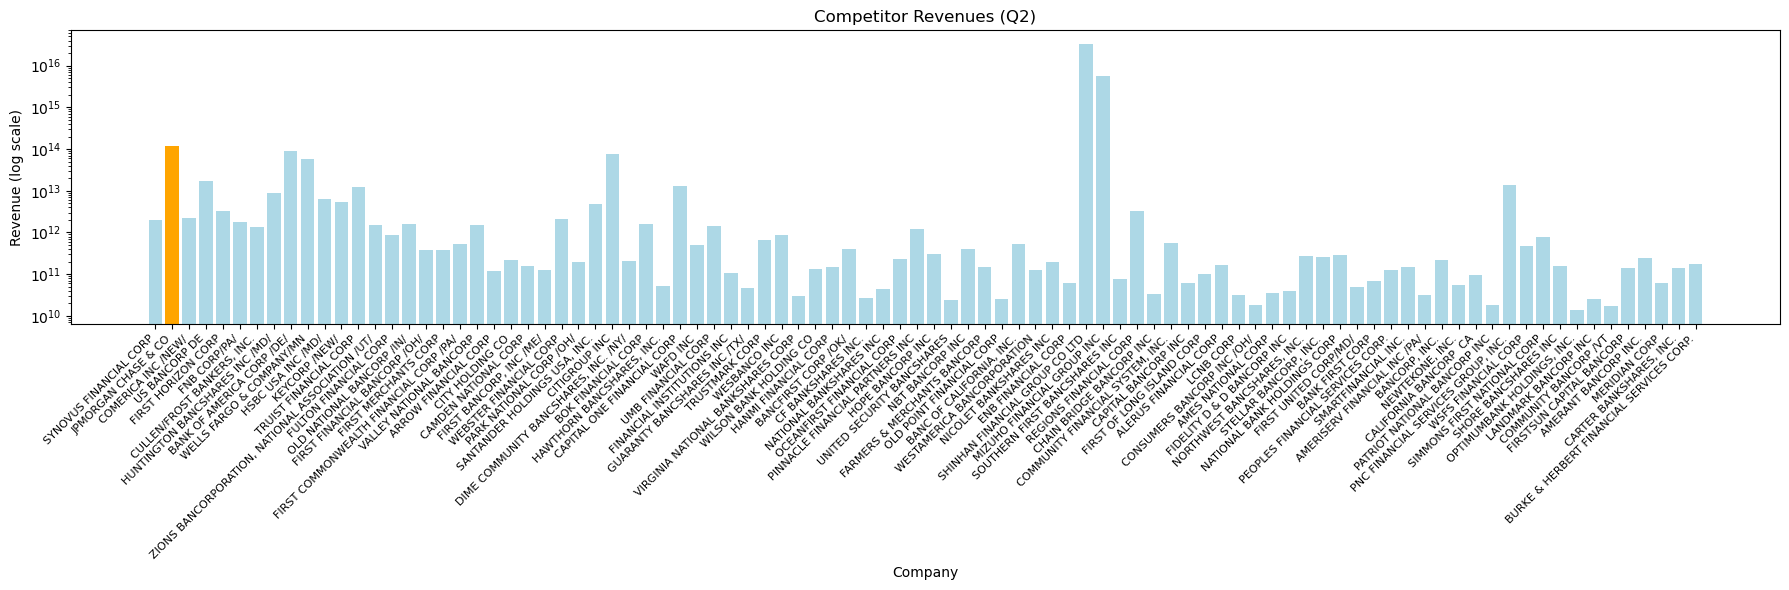

In [7]:
import matplotlib.pyplot as plt

highlight = "JPMORGAN CHASE & CO"

colors = [
    "orange" if name == highlight else "lightblue"
    for name in gross_rev["name"]
]

# Bar chart with log scale on y-axis
plt.figure(figsize=(18,6))
plt.bar(gross_rev["name"], gross_rev["rev"], color=colors)

plt.yscale("log")  
plt.xlabel("Company")
plt.ylabel("Revenue (log scale)")
plt.title("Competitor Revenues (Q2)")

plt.xticks(rotation=45, ha="right", fontsize=8)  # rotate labels for readability
plt.tight_layout()
plt.show()


In [8]:
q1_num.shape

(3658551, 10)

In [9]:
#gross margins, operating margins, and R&D intensity across peers.
q1_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3658551 entries, 0 to 3658550
Data columns (total 10 columns):
 #   Column    Dtype  
---  ------    -----  
 0   adsh      object 
 1   tag       object 
 2   version   object 
 3   ddate     int64  
 4   qtrs      int64  
 5   uom       object 
 6   segments  object 
 7   coreg     object 
 8   value     float64
 9   footnote  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 279.1+ MB


In [10]:
q1_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6231 entries, 0 to 6230
Data columns (total 36 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   adsh        6231 non-null   object 
 1   cik         6231 non-null   int64  
 2   name        6231 non-null   object 
 3   sic         6058 non-null   float64
 4   countryba   6224 non-null   object 
 5   stprba      5518 non-null   object 
 6   cityba      6224 non-null   object 
 7   zipba       6219 non-null   object 
 8   bas1        6225 non-null   object 
 9   bas2        2751 non-null   object 
 10  baph        6225 non-null   object 
 11  countryma   6212 non-null   object 
 12  stprma      5524 non-null   object 
 13  cityma      6214 non-null   object 
 14  zipma       6206 non-null   object 
 15  mas1        6214 non-null   object 
 16  mas2        2754 non-null   object 
 17  countryinc  5623 non-null   object 
 18  stprinc     4968 non-null   object 
 19  ein         6231 non-null  

In [11]:
q1_num["ddate"] = pd.to_datetime(q1_num["ddate"], errors="coerce")
q2_num["ddate"] = pd.to_datetime(q1_num["ddate"], errors="coerce")

In [12]:
q1_sub["period"] = pd.to_datetime(q1_sub["period"], errors="coerce")
q2_sub["period"] = pd.to_datetime(q2_sub["period"], errors="coerce")

In [13]:
q1_sub["filed"] = pd.to_datetime(q1_sub["filed"], errors="coerce")
q2_sub["filed"] = pd.to_datetime(q2_sub["filed"], errors="coerce")

In [14]:
q1_num["segments"] = q1_num["segments"].fillna("")

In [15]:
peer_ciks = (
    q1_sub.loc[q1_sub["sic"] == 6021.0, "cik"]
    .dropna()
    .drop_duplicates()
    .head(25)
    .tolist()
)

In [54]:
fsub = q1_sub[
    (q1_sub["cik"].isin(peer_ciks)) & (q1_sub["form"] == "10-K") & (q1_sub["fp"] == "FY") & (q1_sub["adsh"].notna())].copy()

In [67]:
TAGS = {
    "nii": [
        "NetInterestIncome",
        "NetInterestIncomeLoss",
    ],
    "noninterest_income": [
        "NoninterestIncome",
    ],
    "noninterest_expense": [
        "NoninterestExpense",
    ],
    "pretax_income": [
        "IncomeBeforeIncomeTaxes",
        "IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest",
    ],
}
crit_tags = sorted({t for lst in TAGS.values() for t in lst})


In [69]:
crit_tags = sorted({tag for tlist in TAGS.values() for tag in tlist})

In [71]:
MOST_RECENT_PER_CIK = 5
fsub = (
    fsub.sort_values(["cik", "filed"], ascending=[True, False])
        .groupby("cik", as_index=False)
        .head(MOST_RECENT_PER_CIK)
)

adsh_keep = set(fsub["adsh"])

fnum = q1_num[
        (q1_num["adsh"].isin(adsh_keep)) &
        (q1_num["tag"].isin(crit_tags)) &
        (q1_num["uom"] == "USD") &
        (q1_num["segments"] == "") &
        (q1_num["qtrs"] == 4)
].copy()

fnum = (
    fnum.sort_values(["adsh", "tag", "ddate"])
        .groupby(["adsh", "tag"], as_index=False)
        .tail(1)
)



In [72]:
wide = fnum.pivot_table(index="adsh", columns="tag", values="value", aggfunc="first").reset_index()
df = wide.merge(
    fsub[["adsh", "cik", "name", "sic", "period", "filed"]],
    on="adsh",
    how="left"
)


df = wide.merge(
    fsub[["adsh", "cik", "name", "sic", "period", "filed"]],
    on="adsh",
    how="left"
)

In [73]:
def pick_first_available(row, candidates):
    for t in candidates:
        if t in row.index and pd.notna(row[t]):
            return row[t]
    return np.nan

df["NII"] = df.apply(lambda r: pick_first_available(r, TAGS["nii"]), axis=1)
df["NonInterestIncome"] = df.apply(lambda r: pick_first_available(r, TAGS["noninterest_income"]), axis=1)
df["NonInterestExpense"] = df.apply(lambda r: pick_first_available(r, TAGS["noninterest_expense"]), axis=1)
df["PretaxIncome"] = df.apply(lambda r: pick_first_available(r, TAGS["pretax_income"]), axis=1)



In [79]:
# Total revenue proxy for banks
df["TotalRevenue"] = df["NII"].fillna(0) + df["NonInterestIncome"].fillna(0)
df.loc[df[["NII","NonInterestIncome"]].isna().all(axis=1), "TotalRevenue"] = np.nan

# Efficiency ratio (lower is better)
df["EfficiencyRatio"] = np.where(
    df["TotalRevenue"].gt(0) & df["NonInterestExpense"].notna(),
    df["NonInterestExpense"] / df["TotalRevenue"],
    np.nan
)

# Pretax margin (more meaningful than operating margin for banks)
df["PretaxMargin"] = np.where(
    df["TotalRevenue"].gt(0) & df["PretaxIncome"].notna(),
    df["PretaxIncome"] / df["TotalRevenue"],
    np.nan
)

df["EfficiencyRatio_%"] = df["EfficiencyRatio"] * 100
df["PretaxMargin_%"] = df["PretaxMargin"] * 100


In [83]:
def pct(series):
    return series * 100

df["EfficiencyRatio_%"] = pct(df["EfficiencyRatio"])
df["PretaxMargin_%"] = pct(df["PretaxMargin"])


In [87]:
latest = (
    df.sort_values(["cik", "filed"], ascending=[True, False])
      .groupby("cik", as_index=False)
      .head(1)
      .copy()
)

cols = [
    "cik", "name", "sic", "filed", "period",
    "NII", "NonInterestIncome", "NonInterestExpense", "PretaxIncome",
    "TotalRevenue",
    "EfficiencyRatio_%", "PretaxMargin_%"
]

latest_view = latest.loc[:, [c for c in cols if c in latest.columns]] \
                   .sort_values("PretaxMargin_%", ascending=False)

latest_view

,cik,name,sic,filed,period,NII,NonInterestIncome,NonInterestExpense,PretaxIncome,TotalRevenue,EfficiencyRatio_%,PretaxMargin_%
0,18349,SYNOVUS FINANCIAL CORP,"6,021.00",1970-01-01 00:00:00.020250221,1970-01-01 00:00:00.020241231,NaN,"239,604,000.00","1,247,543,000.00","604,953,000.00","239,604,000.00",520.67,252.48
21,726854,CITY HOLDING CO,"6,021.00",1970-01-01 00:00:00.020250226,1970-01-01 00:00:00.020241231,NaN,"73,334,000.00","147,235,000.00","144,516,000.00","73,334,000.00",200.77,197.07
20,714310,VALLEY NATIONAL BANCORP,"6,021.00",1970-01-01 00:00:00.020250228,1970-01-01 00:00:00.020241231,NaN,"224,501,000.00","1,105,860,000.00","438,519,000.00","224,501,000.00",492.59,195.33
15,707179,OLD NATIONAL BANCORP /IN/,"6,021.00",1970-01-01 00:00:00.020250219,1970-01-01 00:00:00.020241231,NaN,"354,697,000.00","1,094,423,000.00","680,438,000.00","354,697,000.00",308.55,191.84
17,712534,FIRST MERCHANTS CORP,"6,021.00",1970-01-01 00:00:00.020250224,1970-01-01 00:00:00.020241231,NaN,"125,580,000.00","379,266,000.00","231,728,000.00","125,580,000.00",302.01,184.53
18,712537,FIRST COMMONWEALTH FINANCIAL CORP /PA/,"6,021.00",1970-01-01 00:00:00.020250303,1970-01-01 00:00:00.020241231,NaN,"99,231,000.00","270,745,000.00","178,208,000.00","99,231,000.00",272.84,179.59
5,37808,FNB CORP/PA/,"6,021.00",1970-01-01 00:00:00.020250227,1970-01-01 00:00:00.020241231,NaN,"316,000,000.00","961,000,000.00","555,000,000.00","316,000,000.00",304.11,175.63
6,39263,"CULLEN/FROST BANKERS, INC.","6,021.00",1970-01-01 00:00:00.020250206,1970-01-01 00:00:00.020241231,NaN,"459,098,000.00","1,302,758,000.00","695,967,000.00","459,098,000.00",283.76,151.59
23,805676,PARK NATIONAL CORP /OH/,"6,021.00",1970-01-01 00:00:00.020250224,1970-01-01 00:00:00.020241231,NaN,"122,588,000.00","321,339,000.00","184,725,000.00","122,588,000.00",262.13,150.69
4,36966,FIRST HORIZON CORP,"6,021.00",1970-01-01 00:00:00.020250227,1970-01-01 00:00:00.020241231,NaN,"679,000,000.00","2,035,000,000.00","1,005,000,000.00","679,000,000.00",299.71,148.01


In [91]:
stats = (
    latest[["EfficiencyRatio_%", "PretaxMargin_%"]]
    .describe(percentiles=[0.25, 0.5, 0.75])
    .T
)

stats

,count,mean,std,min,25%,50%,75%,max
EfficiencyRatio_%,24.00,276.07,121.06,108.03,192.55,267.49,302.54,561.80
PretaxMargin_%,21.00,127.29,67.32,-37.82,71.60,146.97,179.59,252.48


In [93]:
def parse_yyyymmdd(s):
    s = pd.to_numeric(s, errors="coerce")
    s = s.dropna().astype("int64").astype(str)
    out = pd.Series(pd.NaT, index=s.index)
    out.loc[s.index] = pd.to_datetime(s, format="%Y%m%d", errors="coerce")
    return out

# Apply to df before creating `latest`
df["filed"]  = parse_yyyymmdd(df["filed"])
df["period"] = parse_yyyymmdd(df["period"])

latest = (
    df.sort_values(["cik", "filed"], ascending=[True, False])
      .groupby("cik", as_index=False)
      .head(1)
      .copy()
)


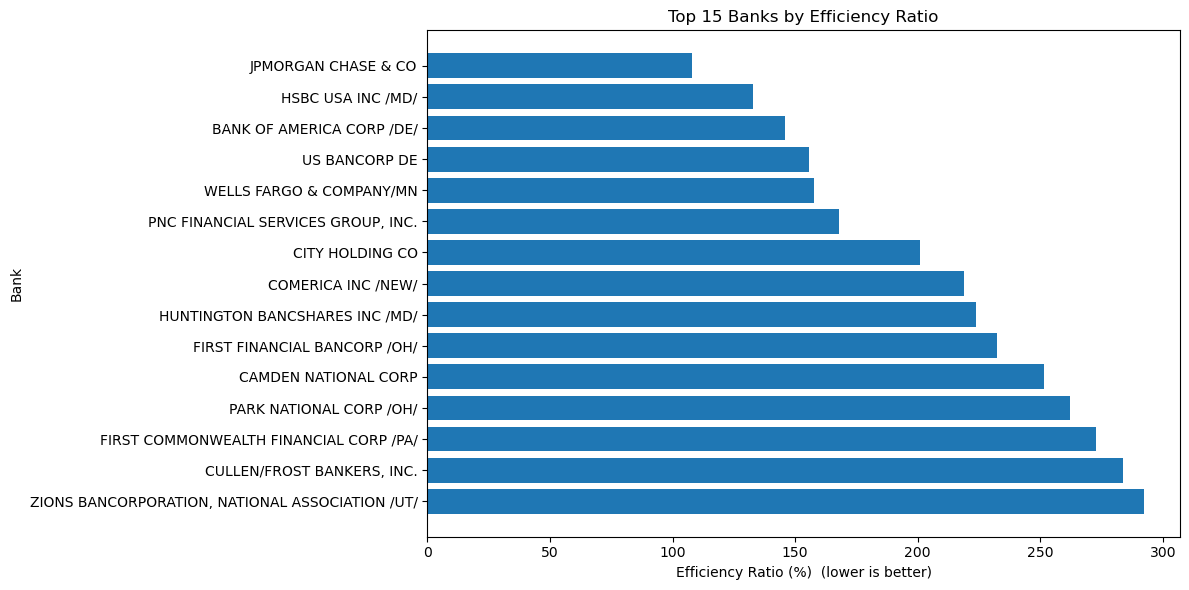

In [95]:
top = (
    latest.dropna(subset=["EfficiencyRatio_%"])
          .sort_values("EfficiencyRatio_%", ascending=True)
          .head(15)
)

plt.figure(figsize=(12,6))
plt.barh(top["name"], top["EfficiencyRatio_%"])
plt.xlabel("Efficiency Ratio (%)  (lower is better)")
plt.ylabel("Bank")
plt.title("Top 15 Banks by Efficiency Ratio")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


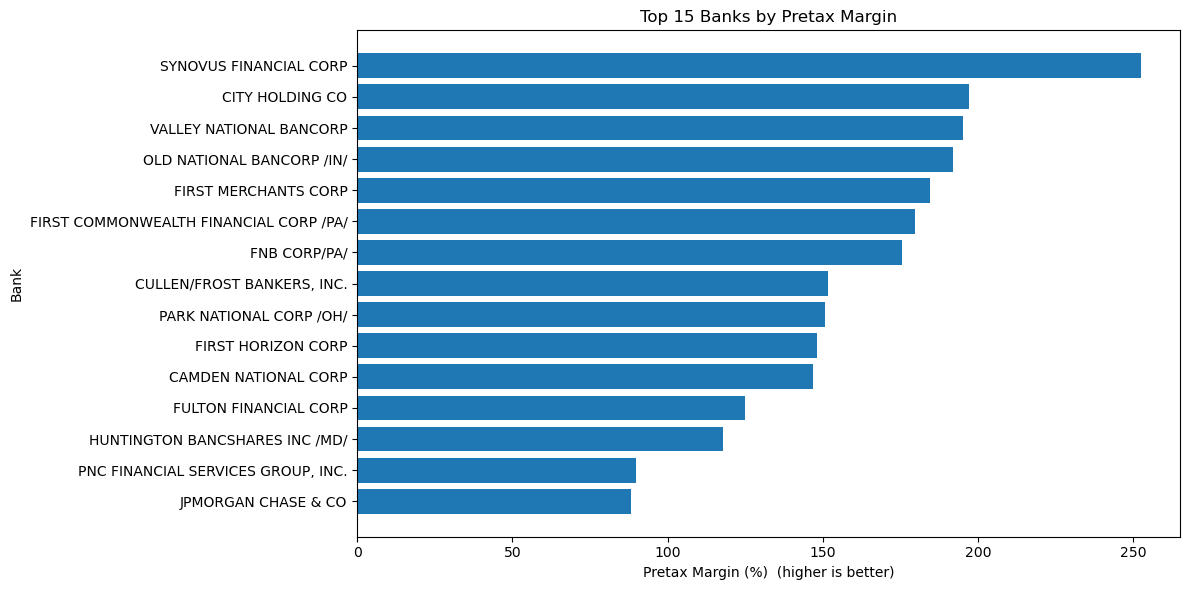

In [97]:
top = (
    latest.dropna(subset=["PretaxMargin_%"])
          .sort_values("PretaxMargin_%", ascending=False)
          .head(15)
)

plt.figure(figsize=(12,6))
plt.barh(top["name"], top["PretaxMargin_%"])
plt.xlabel("Pretax Margin (%)  (higher is better)")
plt.ylabel("Bank")
plt.title("Top 15 Banks by Pretax Margin")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
